## Running PhotoD with LSDB on Gaia-SDSS crossmatch

In [1]:
import os
default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"

import jax
import lsdb
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd

from dask import delayed
from dask.distributed import Client, get_worker
from scipy.interpolate import griddata
from photod.bayes import makeBayesEstimates3d
from photod.locus import LSSTsimsLocus, subsampleLocusData, get3DmodelList
from photod.parameters import GlobalParams


In [4]:
sdss_url = "/mnt/beegfs/scratch/data/Gaia-SDSS/hats/Gaia-SDSS/"
sdss_catalog = lsdb.read_hats(sdss_url)
sdss_catalog

,random_index,ra,dec,phot_g_mean_mag,parallax,parallax_error,source_id,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,objid,type,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,Norder,Dir,Npix
npartitions=63,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 1, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],int64[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 1, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
prior_map_url = "/mnt/beegfs/scratch/data/"
prior_map_catalog = lsdb.read_hats(prior_map_url)
prior_map_catalog

,rmag,kde,xGrid,yGrid,Norder,Dir,Npix
npartitions=207,,,,,,,
"Order: 5, Pixel: 0",double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...


In [9]:
gaia_distances = lsdb.read_hats('https://data.lsdb.io/hats/gaia_dr3/gaia_edr3_distances', margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_edr3_distances_10arcs')
gaia_distances

,source_id,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,ra,dec,Norder,Dir,Npix
npartitions=3243,,,,,,,,,,,,,
"Order: 2, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow]
"Order: 3, Pixel: 4",...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 766",...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 767",...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
locus_path = "/home/scampos/photoD/data/MSandRGBcolors_v1.3.txt"
fitColors = ("ug", "gr", "ri", "iz")
LSSTlocus = LSSTsimsLocus(fixForStripe82=False, datafile=locus_path)
OKlocus = LSSTlocus[(LSSTlocus["gi"] > 0.2) & (LSSTlocus["gi"] < 3.55)]
locusData = subsampleLocusData(OKlocus, kMr=10, kFeH=2)
ArGridList, locus3DList = get3DmodelList(locusData, fitColors)
globalParams = GlobalParams(fitColors, locusData, ArGridList, locus3DList)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [5]:
def merging_function(partition, map_partition, partition_pixel, map_pixel, globalParams, worker_dict, *kwargs):
    priorGrid = {}
    for rind, r in enumerate(np.sort(map_partition["rmag"].to_numpy())):
        # interpolate prior map onto locus Mr-FeH grid
        Z = map_partition[map_partition["rmag"] == r]
        Zval = np.frombuffer(Z.iloc[0]["kde"], dtype=np.float64).reshape((96, 36))
        X = np.frombuffer(Z.iloc[0]["xGrid"], dtype=np.float64).reshape((96, 36))
        Y = np.frombuffer(Z.iloc[0]["yGrid"], dtype=np.float64).reshape((96, 36))
        points = np.array((X.flatten(), Y.flatten())).T
        values = Zval.flatten()
        # actual (linear) interpolation
        priorGrid[rind] = griddata(
            points, values, (globalParams.locusData["FeH"], globalParams.locusData[globalParams.MrColumn]), method="linear", fill_value=0
        )
    gpu_device = jax.devices()[worker_dict[get_worker().id]]
    with jax.default_device(gpu_device):
        priorGrid = jax.numpy.array(list(priorGrid.values()))
        estimatesDf, _ = makeBayesEstimates3d(partition, priorGrid, globalParams, batchSize=10)
    return pd.concat([partition[["ra", "dec"]], npd.NestedFrame(estimatesDf)], axis=1)

In [7]:
def get_worker_dict():
    res = s82_stripe_catalog._ddf.partitions[0:5].map_partitions(lambda df: pd.DataFrame.from_dict({"workers":[get_worker().id]}), meta={"workers": object}).compute()
    worker_ids = np.unique(res["workers"].to_numpy())
    worker_dict = {id: i for i, id in enumerate(worker_ids)}
    print(worker_dict)
    return worker_dict

In [6]:
col_names = ["ra","dec","glon","glat","FeHEst","FeHUnc","MrEst","MrUnc","chi2min","MrdS","FeHdS","ArEst","ArUnc","ArdS","D","DUnc"]
meta = npd.NestedFrame.from_dict({ col: pd.Series([], dtype=float) for col in col_names})
meta.index.name = "_healpix_29"

In [10]:
with Client(n_workers=4) as client:
    worker_dict = get_worker_dict()
    delayed_global_params = delayed(globalParams)
    merge_lazy = s82_stripe_catalog.merge_map(prior_map_catalog, merging_function, globalParams=delayed_global_params, worker_dict=worker_dict, meta=meta)
    crossmatched = merge_lazy.crossmatch(gaia_distances)
    xmatch_result = crossmatched.compute()
xmatch_result

/home/scampos/photoD/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44513 instead
  warnings.warn(


{'Worker-585881cc-89a1-4b41-b5b9-a4e2f284b900': 0, 'Worker-64c3daa1-5069-41cc-9a76-20807e0722be': 1, 'Worker-97f59613-4043-4d4c-afcf-ef82df0367e2': 2, 'Worker-dfe06f9d-bfa9-47d0-8a0a-c076b939cbf0': 3}


/home/scampos/photoD/.venv/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 79.09 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,ra_S82_fixed,dec_S82_fixed,glon_S82_fixed,glat_S82_fixed,FeHEst_S82_fixed,FeHUnc_S82_fixed,MrEst_S82_fixed,MrUnc_S82_fixed,chi2min_S82_fixed,MrdS_S82_fixed,...,r_med_photogeo_gaia_edr3_distances,r_lo_photogeo_gaia_edr3_distances,r_hi_photogeo_gaia_edr3_distances,flag_gaia_edr3_distances,ra_gaia_edr3_distances,dec_gaia_edr3_distances,Norder_gaia_edr3_distances,Dir_gaia_edr3_distances,Npix_gaia_edr3_distances,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,
162211513082,44.995031,0.038152,176.914264,-48.879749,-0.379619,0.223275,10.601394,0.211412,0.447543,-37.352390,...,894.886536,740.259399,1037.2533,10033,44.995037,0.038152,2,0.0,0.0,0.022146
187874205331,44.963869,0.043597,176.875399,-48.898395,-0.608126,0.123861,6.405376,0.146170,17.926819,-39.963490,...,2312.65527,2050.8374,2602.06006,10033,44.963896,0.043595,2,0.0,0.0,0.098435
268254148314,44.998317,0.06634,176.88689,-48.857814,-2.232135,0.158194,4.075833,0.578908,0.192304,-23.896175,...,5598.27002,4505.23193,6764.95508,11033,44.998327,0.066333,2,0.0,0.0,0.044784
282956553349,45.048274,0.048304,176.959307,-48.834366,-0.866308,0.055142,6.366106,0.056288,26.733196,-47.315948,...,616.651428,603.039551,628.16156,10033,45.048282,0.048254,2,0.0,0.0,0.182617
425727624950,45.023562,0.068453,176.911213,-48.838178,-0.535173,0.080353,6.941675,0.109744,35.408913,-41.117924,...,811.626465,768.958496,852.594788,10033,45.02362,0.068419,2,0.0,0.0,0.241828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458764488921378833,314.983478,-0.019971,48.889173,-28.256075,-0.413612,0.247434,10.247563,0.231156,0.559832,-30.283442,...,400.299591,376.472382,422.925659,10033,314.983418,-0.020028,3,0.0,767.0,0.296106
3458764491323291543,314.983523,-0.017944,48.891169,-28.255065,-0.322921,0.208012,10.096582,0.208678,6.671353,-34.317211,...,2046.27917,1743.60352,2379.9353,10033,314.983513,-0.017962,3,0.0,767.0,0.07487
3458764494738379595,314.985876,-0.014536,48.895862,-28.255315,-0.374013,0.241811,10.492229,0.238628,9.550972,-32.273098,...,2105.90015,1608.70532,2510.09351,10033,314.985882,-0.014514,3,0.0,767.0,0.083264


In [11]:
xmatch_result[["r_med_photogeo_gaia_edr3_distances", "r_lo_geo_gaia_edr3_distances", "r_hi_geo_gaia_edr3_distances", "D_S82_fixed", "DUnc_S82_fixed"]]

,r_med_photogeo_gaia_edr3_distances,r_lo_geo_gaia_edr3_distances,r_hi_geo_gaia_edr3_distances,D_S82_fixed,DUnc_S82_fixed
_healpix_29,,,,,
162211513082,894.886536,589.630127,980.245239,688.867406,68.078076
187874205331,2312.65527,2366.11499,4843.74707,1961.171423,135.515142
268254148314,5598.27002,1995.62415,10343.4902,9886.021366,2676.109538
282956553349,616.651428,604.024353,626.47345,438.951855,11.589071
425727624950,811.626465,780.013733,868.960449,764.225896,40.959415
...,...,...,...,...,...
3458764488921378833,400.299591,367.670593,411.647644,401.253973,42.909476
3458764491323291543,2046.27917,1159.85645,4868.9209,1316.061252,131.810726
3458764494738379595,2105.90015,512.631775,1935.8219,1118.024346,130.599012


In [12]:
mod_err = (xmatch_result["r_hi_photogeo_gaia_edr3_distances"].to_numpy() - xmatch_result["r_lo_photogeo_gaia_edr3_distances"].to_numpy()) / 2
obs_err = xmatch_result["DUnc_S82_fixed"].to_numpy()
normalized_residual = (xmatch_result["D_S82_fixed"].to_numpy() - xmatch_result["r_med_photogeo_gaia_edr3_distances"].to_numpy()) / np.sqrt(obs_err ** 2 + mod_err ** 2)
normalized_residual

array([-1.26114802, -1.14443138,  1.47606671, ..., -2.10529114,
       -1.50003853,  1.82086164])

In [13]:
mean_kh = np.nanmean(normalized_residual)
std_kh = np.nanstd(normalized_residual)
mean_kh, std_kh

(-0.900905699617563, 2.499055536391347)

Text(0.5, 1.0, 'Normalized residual with mean -0.90 and std 2.50')

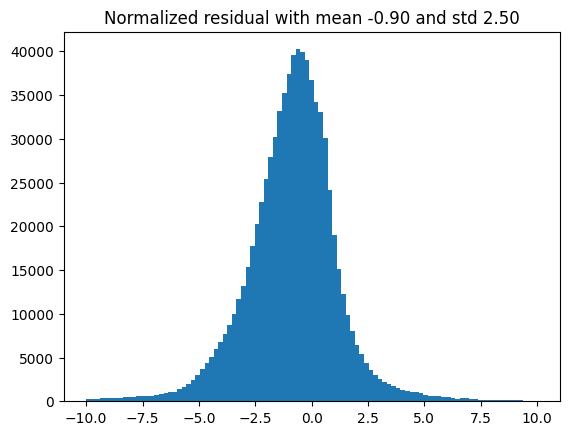

In [14]:
histog = plt.hist(normalized_residual, bins=np.linspace(-10, 10, 100))
plt.title(f"Normalized residual with mean {mean_kh:.2f} and std {std_kh:.2f}")